Some of the code in this lab was taken from the solution at https://github.com/learn-co-curriculum/dsc-tuning-neural-networks-from-start-to-finish-lab/tree/solution

# Tuning and Optimizing Neural Networks - Lab

## Introduction

Now that you've seen some regularization, initialization and optimization techniques, its time to synthesize those concepts into a cohesive modeling pipeline.  

With this pipeline, you will not only fit an initial model but will also attempt to set various hyperparameters for regularization techniques. Your final model selection will pertain to the test metrics across these models. This will more naturally simulate a problem you might be faced with in practice, and the various modeling decisions you are apt to encounter along the way.  

Recall that our end objective is to achieve a balance between overfitting and underfitting. You've seen the bias variance trade-off, and the role of regularization in order to reduce overfitting on training data and improving generalization to new cases. Common frameworks for such a procedure include train/validate/test methodology when data is plentiful, and K-folds cross-validation for smaller, more limited datasets. In this lab, you'll perform the latter, as the dataset in question is fairly limited. 

## Objectives

You will be able to:

* Implement a K-folds cross validation modeling pipeline
* Apply normalization as a preprocessing technique
* Apply regularization techniques to improve your model's generalization
* Choose an appropriate optimization strategy 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Loading the Data

Load and preview the dataset below.

In [2]:
# this code was taken from the solution at https://github.com/learn-co-curriculum/dsc-tuning-neural-networks-from-start-to-finish-lab/tree/solution
# Your code here; load and preview the dataset
df = pd.read_csv('loan_final.csv')
df.dropna(subset=['total_pymnt'], inplace=True)
print(df.shape)
df.head()

(42535, 16)


,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,total_acc,total_pymnt,application_type
0,5000.0,4975.0,36 months,10.65%,162.87,B,10+ years,RENT,24000.0,Verified,Fully Paid,credit_card,AZ,9.0,5863.155187,Individual
1,2500.0,2500.0,60 months,15.27%,59.83,C,< 1 year,RENT,30000.0,Source Verified,Charged Off,car,GA,4.0,1014.530000,Individual
2,2400.0,2400.0,36 months,15.96%,84.33,C,10+ years,RENT,12252.0,Not Verified,Fully Paid,small_business,IL,10.0,3005.666844,Individual
3,10000.0,10000.0,36 months,13.49%,339.31,C,10+ years,RENT,49200.0,Source Verified,Fully Paid,other,CA,37.0,12231.890000,Individual
4,3000.0,3000.0,60 months,12.69%,67.79,B,1 year,RENT,80000.0,Source Verified,Fully Paid,other,OR,38.0,4066.908161,Individual


## Defining the Problem

Set up the problem by defining X and y. 

For this problem use the following variables for X:
* loan_amnt
* home_ownership
* funded_amnt_inv
* verification_status
* emp_length
* installment
* annual_inc

Our target variable y will be ```total_pymnt```

In [3]:
df.columns

Index(['loan_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment',
       'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'loan_status', 'purpose', 'addr_state',
       'total_acc', 'total_pymnt', 'application_type'],
      dtype='object')

In [4]:
# Your code here; appropriately define X and y and apply a trian test split
X = df[['loan_amnt', 'home_ownership', 'funded_amnt_inv', 'verification_status', 'emp_length', 'installment', 'annual_inc']]
y = df['total_pymnt']


## Generating a Hold Out Test Set

While we will be using K-fold cross validation to select an optimal model, we still want a final hold out test set that is completely independent of any modeling decisions. As such, pull out a sample of 10% of the total available data. For consistency of results, use random seed 123. 

In [5]:
# Your code here; generate a hold out test set for final model evaluation. Use random seed 123.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

### Preprocessing Steps
* Fill in missing values with SimpleImputer
* Standardize continuous features with StandardScalar()
* One hot encode categorical features with OneHotEncoder()

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42535 entries, 0 to 42537
Data columns (total 7 columns):
loan_amnt              42535 non-null float64
home_ownership         42535 non-null object
funded_amnt_inv        42535 non-null float64
verification_status    42535 non-null object
emp_length             41423 non-null object
installment            42535 non-null float64
annual_inc             42531 non-null float64
dtypes: float64(4), object(3)
memory usage: 2.6+ MB


In [7]:
# this code was taken from the solution at https://github.com/learn-co-curriculum/dsc-tuning-neural-networks-from-start-to-finish-lab/tree/solution
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# get continuos feats
cont_feats = ['loan_amnt', 'funded_amnt_inv', 'installment', 'annual_inc']
X_train_cont = X_train.loc[:, cont_feats]

# fill missing values with the mean
si_cont = SimpleImputer(strategy='mean')
si_cont.fit(X_train_cont)
X_train_cont = si_cont.transform(X_train_cont)

# standardize inputs
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train_cont)

# create cont feats dataframe
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_feats)

# select categorical features
cat_feats = ['home_ownership', 'verification_status', 'emp_length']
X_train_cat = X_train.loc[:, cat_feats]

# replace nans with 'missing'
si_cat = SimpleImputer(strategy='constant', fill_value='missing')
si_cat.fit(X_train_cat)
X_train_cat = si_cat.transform(X_train_cat)

# Encode categorical features
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train_cat)
X_train_cat = ohe.transform(X_train_cat)

# create categorical feature dataframe
X_train_cat_df = pd.DataFrame(X_train_cat.todense(), columns=ohe.get_feature_names(input_features=cat_feats))

# combine continuos and categorical dataframes
X_train = pd.concat([X_train_scaled_df, X_train_cat_df], axis=1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31901 entries, 0 to 31900
Data columns (total 24 columns):
loan_amnt                              31901 non-null float64
funded_amnt_inv                        31901 non-null float64
installment                            31901 non-null float64
annual_inc                             31901 non-null float64
home_ownership_MORTGAGE                31901 non-null float64
home_ownership_NONE                    31901 non-null float64
home_ownership_OTHER                   31901 non-null float64
home_ownership_OWN                     31901 non-null float64
home_ownership_RENT                    31901 non-null float64
verification_status_Not Verified       31901 non-null float64
verification_status_Source Verified    31901 non-null float64
verification_status_Verified           31901 non-null float64
emp_length_1 year                      31901 non-null float64
emp_length_10+ years                   31901 non-null float64
emp_length_2 years     

### Preprocess Your Holdout Set

Make sure to use your StandardScalar and OneHotEncoder that you already fit on the training set to transform your test set

In [8]:
# fill mising values with mean for continous feats
X_test_cont = X_test.loc[:, cont_feats]
X_test_cont = si_cont.transform(X_test_cont)

# scale continuos feats
X_test_scaled = sc.transform(X_test_cont)

# create dataframe for continous feats
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_feats)

# fill missing values for categorical feats
X_test_cat = X_test.loc[:, cat_feats]
X_test_cat = si_cat.transform(X_test_cat)

# one hot encode categorical feats
X_test_cat = ohe.transform(X_test_cat)

# create dataframe for categorical feats
X_test_cat_df = pd.DataFrame(X_test_cat.todense(), columns=ohe.get_feature_names(input_features=cat_feats))

# combine dataframes
X_test = pd.concat([X_test_scaled_df, X_test_cat_df], axis=1)


X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10634 entries, 0 to 10633
Data columns (total 24 columns):
loan_amnt                              10634 non-null float64
funded_amnt_inv                        10634 non-null float64
installment                            10634 non-null float64
annual_inc                             10634 non-null float64
home_ownership_MORTGAGE                10634 non-null float64
home_ownership_NONE                    10634 non-null float64
home_ownership_OTHER                   10634 non-null float64
home_ownership_OWN                     10634 non-null float64
home_ownership_RENT                    10634 non-null float64
verification_status_Not Verified       10634 non-null float64
verification_status_Source Verified    10634 non-null float64
verification_status_Verified           10634 non-null float64
emp_length_1 year                      10634 non-null float64
emp_length_10+ years                   10634 non-null float64
emp_length_2 years     

In [9]:
# normalize
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

for col in X:
    X[col] = (X[col] - X[col].mean()) / X[col].std()

y = (y - y.mean()) / y.std()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# Defining a K-fold Cross Validation Methodology

Now that your have a complete holdout test set, write a function that takes in the remaining data and performs k-folds cross validation given a model object. 

> Note: Think about how you will analyze the output of your models in order to select an optimal model. This may involve graphs, although alternative approaches are certainly feasible.

In [11]:
# this code was taken from the solution at https://github.com/learn-co-curriculum/dsc-tuning-neural-networks-from-start-to-finish-lab/tree/solution
# Your code here; define a function to evaluate a model object using K folds cross validation.
from sklearn.model_selection import KFold
import seaborn as sns



def k_folds(features_train, labels_train, model_obj, k=10, n_epochs=100):
    # set colors
    colors = sns.color_palette("Set2")
    
    # list to hold validation scores
    validation_scores = []
    
    #KFold object
    kf = KFold(n_splits=10, shuffle=True)
    
    #subplots
    fig, axes = plt.subplots(2, 5, figsize=(12, 8))
    
    # for each test create graph of loss and record validation score
    for i, (train_index, test_index) in enumerate(kf.split(features_train)):
        row = i//5
        col = i%5
        
        X_train, X_val = features_train.iloc[train_index], features_train.iloc[test_index]
        y_train, y_val = labels_train.iloc[train_index], labels_train.iloc[test_index]
        
        model = model_obj
        
        hist = model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, verbose=0, validation_data=(X_val, y_val))
        
        validation_score = model.evaluate(X_val, y_val)
        validation_scores.append(validation_score)
        
        ax = axes[row, col]
        k = 'val_loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[0])
        
        k = 'loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[1])
        ax.set_title('Fold {} Validation'.format(i+1))
        
    # Final graph formating
    plt.subplots_adjust(wspace=0.5)
    plt.legend(bbox_to_anchor=(1,1))
    
    # General overview
    validation_score = np.mean(validation_scores)
    print('Mean Validation Score:', validation_score)
    print('STD of Validation Scores:', np.std(validation_scores))
    
    # Return mean validation score
    return validation_score

## Building a Baseline Model

Here, it is also important to define your evaluation metric that you will look to optimize while tuning the model. Additionally, model training to optimize this metric may consist of using a validation and test set if data is plentiful, or k-folds cross-validation if data is limited. Since this dataset is not overly large, it will be most appropriate to set up a k-folds cross-validation  

In [12]:
# this code was taken from the solution at https://github.com/learn-co-curriculum/dsc-tuning-neural-networks-from-start-to-finish-lab/tree/solution
# Your code here; define and compile an initial model as described

input_dim = X_train.shape[1]
model = models.Sequential()
model.add(layers.Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, kernel_initializer='normal', activation='linear'))
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

## Evaluating the Baseline Model with K-Folds Cross Validation

Use your k-folds function to evaluate the baseline model.  

Note: This code block is likely to take 10-20 minutes to run depending on the specs on your computer.
Because of time dependencies, it can be interesting to begin timing these operations for future reference.

Here's a simple little recipe to achieve this:
```
import time
import datetime

now = datetime.datetime.now()
later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)
```

3190/3190 [==============================] - 0s 9us/step
Mean Validation Score: 0.1866511835081322
STD of Validation Scores: 0.009635938350810577
Time Elapsed: 0:08:26.293937


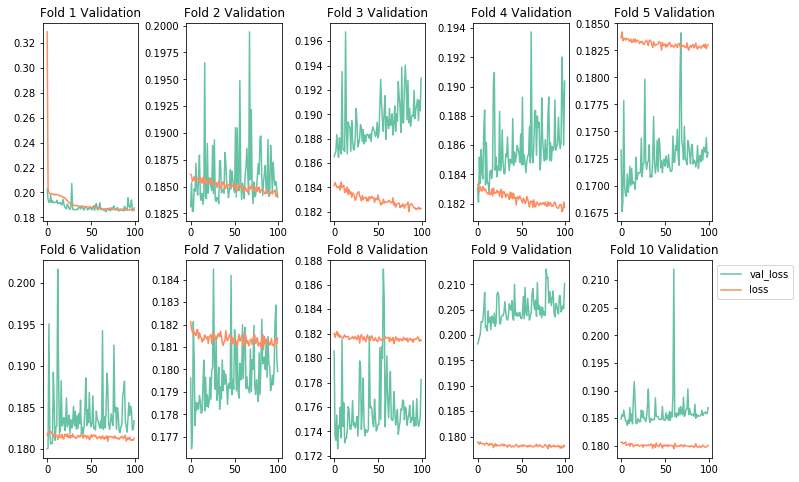

In [13]:
# Your code here; use your k-folds function to evaluate the baseline model.
# ⏰ This cell may take several mintes to run
import datetime

now = datetime.datetime.now()
##################################
k_folds(X_train, y_train, model)
##################################
later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

## Intentionally Overfitting a Model

Now that you've developed a baseline model, its time to intentionally overfit a model. To overfit a model, you can:
* Add layers
* Make the layers bigger
* Increase the number of training epochs

Again, be careful here. Think about the limitations of your resources, both in terms of your computers specs and how much time and patience you have to let the process run. Also keep in mind that you will then be regularizing these overfit models, meaning another round of experiments and more time and resources.

3190/3190 [==============================] - 0s 8us/step
Mean Validation Score: 0.18731160312954062
STD of Validation Scores: 0.012544107700481665


0.18731160312954062

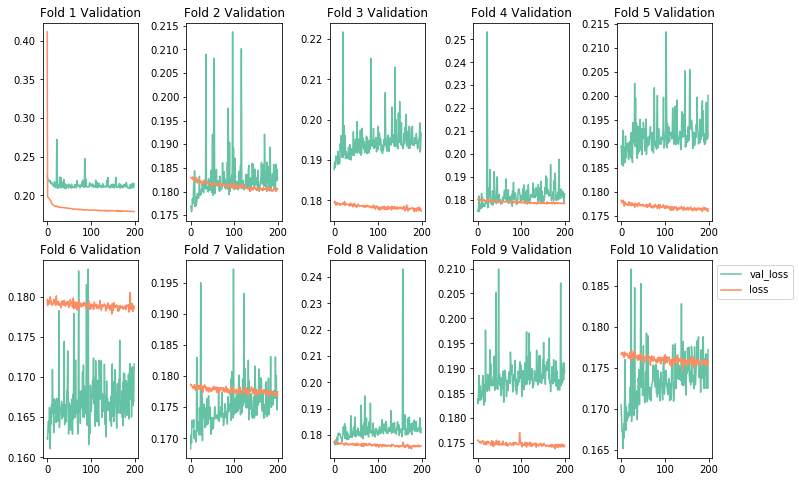

In [14]:
# Your code here; try some methods to overfit your network
model2 = models.Sequential()
model2.add(layers.Dense(7,input_dim=input_dim, kernel_initializer='normal', activation='relu' ))
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(1, activation='linear', kernel_initializer='normal'))
model2.compile(optimizer='sgd', loss='mse', metrics=['mse'])


k_folds(X_train, y_train, model2, n_epochs=200)
# ⏰ This cell may take several mintes to run

In [15]:
# Your code here; try some methods to overfit your network
# ⏰ This cell may take several mintes to run

In [16]:
# Your code here; try some methods to overfit your network
# ⏰ This cell may take several mintes to run

## Regularizing the Model to Achieve Balance  

Now that you have a powerful model (albeit an overfit one), we can now increase the generalization of the model by using some of the regularization techniques we discussed. Some options you have to try include:  
* Adding dropout
* Adding L1/L2 regularization
* Altering the layer architecture (add or remove layers similar to above)  

This process will be constrained by time and resources. Be sure to test at least 2 different methodologies, such as dropout and L2 regularization. If you have the time, feel free to continue experimenting.

Notes: 

3190/3190 [==============================] - 0s 10us/step
Mean Validation Score: 0.19496567688178107
STD of Validation Scores: 0.011519950370094187


0.19496567688178107

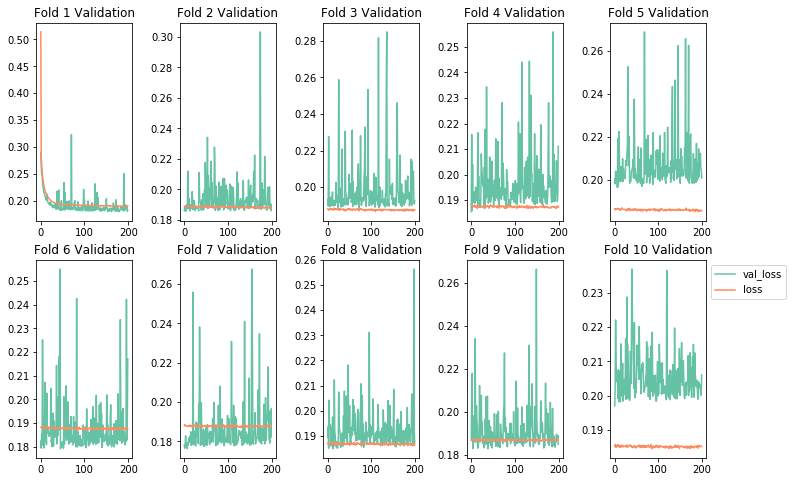

In [19]:
# Your code here; try some regularization or other methods to tune your network
# ⏰ This cell may take several mintes to run
from keras import regularizers

model3 = models.Sequential()
model3.add(layers.Dense(7,input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model3.add(layers.Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model3.add(layers.Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model3.add(layers.Dense(1, activation='linear', kernel_initializer='normal'))
model3.compile(optimizer='sgd', loss='mse', metrics=['mse'])

k_folds(X_train, y_train, model3, n_epochs=200)


3190/3190 [==============================] - 0s 11us/step
Mean Validation Score: 0.23550191273808857
STD of Validation Scores: 0.015140307443144487


0.23550191273808857

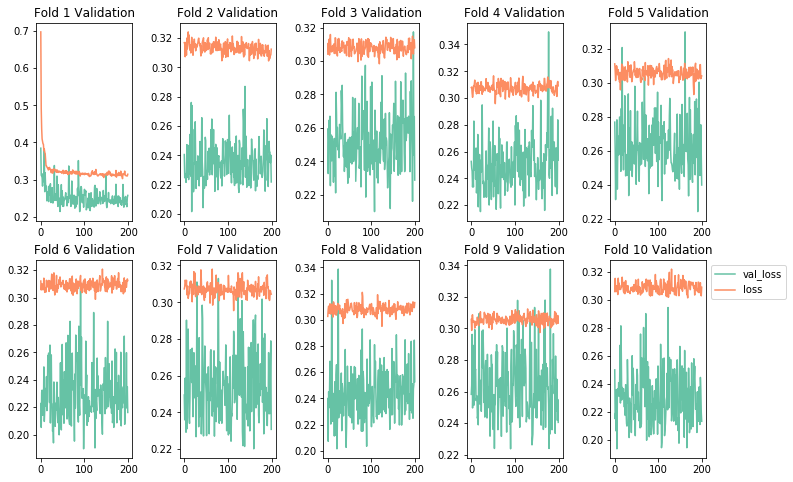

In [20]:
# Your code here; try some regularization or other methods to tune your network
# ⏰ This cell may take several mintes to run
model4 = models.Sequential()
model4.add(layers.Dense(7,input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model4.add(layers.Dense(10, activation='relu'))
model4.add(layers.Dropout(0.3))
model4.add(layers.Dense(10, activation='relu'))
model4.add(layers.Dropout(0.3))
model4.add(layers.Dense(1, activation='linear', kernel_initializer='normal'))
model4.compile(optimizer='sgd', loss='mse', metrics=['mse'])

k_folds(X_train, y_train, model4, n_epochs=200)

## Final Evaluation

Now that you have selected a network architecture, tested various regularization procedures and tuned hyperparameters via a validation methodology, it is time to evaluate your finalized model once and for all. Fit the model using all of the training and validation data using the architecture and hyperparameters that were most effective in your experiments above. Afterwards, measure the overall performance on the hold-out test data which has been left untouched (and hasn't leaked any data into the modeling process)!

In [23]:
# Your code here; final model training on entire training set followed by evaluation on hold-out data

model3 = models.Sequential()
model3.add(layers.Dense(7,input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model3.add(layers.Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model3.add(layers.Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model3.add(layers.Dense(1, activation='linear', kernel_initializer='normal'))
model3.compile(optimizer='sgd', loss='mse', metrics=['mse'])

hist = model3.fit(X_train, y_train, batch_size=32, epochs=200)
model.evaluate(X_test, y_test)
# ⏰ This cell may take several mintes to run

Epoch 1/200
31901/31901 [==============================] - 1s 21us/step - loss: 0.6017 - mse: 0.5161
Epoch 2/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.3094 - mse: 0.2354
Epoch 3/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.2714 - mse: 0.2086
Epoch 4/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.2537 - mse: 0.2002
Epoch 5/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.2427 - mse: 0.1971
Epoch 6/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.2343 - mse: 0.1954
Epoch 7/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.2276 - mse: 0.1942
Epoch 8/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.2219 - mse: 0.1931
Epoch 9/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.2174 - mse: 0.1923
Epoch 10/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.2135 - m

31901/31901 [==============================] - 1s 19us/step - loss: 0.1893 - mse: 0.1851
Epoch 82/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.1889 - mse: 0.1848
Epoch 83/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.1894 - mse: 0.1852
Epoch 84/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.1893 - mse: 0.1852
Epoch 85/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.1893 - mse: 0.1852
Epoch 86/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.1893 - mse: 0.1852
Epoch 87/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.1893 - mse: 0.1852
Epoch 88/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.1894 - mse: 0.1853
Epoch 89/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.1895 - mse: 0.1854
Epoch 90/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.1889 - mse: 

31901/31901 [==============================] - 1s 18us/step - loss: 0.1880 - mse: 0.1843
Epoch 161/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.1878 - mse: 0.1841
Epoch 162/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.1886 - mse: 0.1849
Epoch 163/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.1882 - mse: 0.1846
Epoch 164/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.1881 - mse: 0.1844
Epoch 165/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.1879 - mse: 0.1842
Epoch 166/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.1882 - mse: 0.1846
Epoch 167/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.1883 - mse: 0.1846
Epoch 168/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.1881 - mse: 0.1844
Epoch 169/200
31901/31901 [==============================] - 1s 19us/step - loss: 0.188

[0.19122295954609939, 0.19122301042079926]

## Summary

In this lab, you investigated some data from *The Lending Club* in a complete data science pipeline regarding neural networks. You began with reserving a hold-out set for testing which never was touched during the modeling phase. From there, you implemented a k-fold cross validation methodology in order to assess an initial baseline model and various regularization methods. From here, you'll begin to investigate other neural network architectures such as CNNs.